# Mutton CNN training 

In [75]:
# Imports
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

# Imports
import tensorflow as tf

## Utilities

In [76]:
def one_hot(labels, n_class = 4):
	""" One-hot encoding """
	expansion = np.eye(n_class)
	y = expansion[:, labels-1].T
	assert y.shape[1] == n_class, "Wrong number of labels!"

	return y

def get_batches(X, y, batch_size = 100):
	""" Return a generator for batches """
	n_batches = len(X) // batch_size
	X, y = X[:n_batches*batch_size], y[:n_batches*batch_size]

	# Loop over batches and yield
	for b in range(0, len(X), batch_size):
		yield X[b:b+batch_size], y[b:b+batch_size]

def standardize(train):
	""" Standardize data """

	# Standardize train and test
	X_train = (train - np.mean(train, axis=0)[None,:,:]) / np.std(train, axis=0)[None,:,:]

	return X_train

## Prepare data

In [77]:
path_ = "_Train.csv"

X_train = pd.read_csv(path_).values
print(X_train.shape)

(43364, 3)


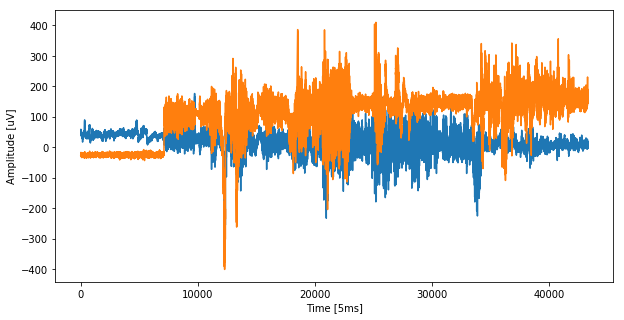

In [78]:
plt.figure(figsize=(10,5))

plt.ylabel('Amplitude [uV]')
plt.xlabel('Time [5ms]')
rData = X_train[:,0]
rDataNum = rData.shape[0]
plt.plot(range(rDataNum), rData)
rData = X_train[:,1]
rDataNum = rData.shape[0]
plt.plot(range(rDataNum), rData)


In [79]:
from scipy import signal

def sine_generator(fs, sinefreq, duration):
    T = duration
    nsamples = fs * T
    w = 2. * np.pi * sinefreq
    t_sine = np.linspace(0, T, nsamples, endpoint=False)
    y_sine = np.sin(w * t_sine)
    result = pd.DataFrame({ 
        'data' : y_sine} ,index=t_sine)
    return result

def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

In [80]:
seq_len = 512

def window_data(seq_len,data) :
    res = [] # n * (128 X 2)
    num_ch = 2
    for i in range(data.shape[0] - seq_len + 1):
        tmp = []
        tmp.append(data[i:i+seq_len, 0:2])
        
        class_label = int(data[i,2])
        if(class_label == 0):
            tmp.append(0)
        elif(class_label == 1):
            tmp.append(1)
        elif(class_label == 2):
            tmp.append(2)
        elif(class_label == 3):
            tmp.append(3)
        
        res.append(tmp)
    return np.asarray(res)

training_data = window_data(seq_len, X_train)

input_train = training_data[:, 0]
label_train = training_data[:, 1]

train_input = []
for data in input_train :
    train_input.append(data)
train_input = np.asarray(train_input)
print(train_input.shape)

label_input = []
for data in label_train :
    label_input.append(data)
label_input = np.asarray(label_input)
print(label_input.shape)

(42853, 512, 2)
(42853,)


In [81]:
fps = 200

fData0 = []
fData1 = []
for data in train_input:
    data[:,0] = butter_highpass_filter(data[:,0],50,fps)
    data[:,1] = butter_highpass_filter(data[:,1],50,fps)

    fData0.append(data[0,0])
    fData1.append(data[0,1])
fData = []
fData.append(fData0)
fData.append(fData1)
fData = np.asarray(fData)

print(train_input.shape)
print(label_input.shape)
print(fData.shape)

(42853, 512, 2)
(42853,)
(2, 42853)


Train/Validation Split

In [40]:
X_tr, X_vld, lab_tr, lab_vld = train_test_split(
    train_input, label_input,
    stratify = label_input, random_state = 123)

print(X_tr.shape)
print(X_vld.shape)
print(lab_tr.shape)
print(lab_vld.shape)

(32139, 512, 2)
(10714, 512, 2)
(32139,)
(10714,)


One-hot encoding:

In [41]:
y_tr = one_hot(lab_tr, 4)
y_vld = one_hot(lab_vld, 4)

print(y_tr.shape)
print(y_vld.shape)

(32139, 4)
(10714, 4)


### Hyperparameters

In [48]:
seq_len = seq_len          # Number of steps
n_classes = 4
n_channels = 2

### Construct the graph
Placeholders

In [50]:
graph = tf.Graph()

# Construct placeholders
with graph.as_default():
    inputs_ = tf.placeholder(tf.float32, [None, seq_len, n_channels], name = 'inputs')
    labels_ = tf.placeholder(tf.float32, [None, n_classes], name = 'labels')
    
    keep_prob_ = tf.placeholder(tf.float32, name = 'keep')
    learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate')

In [51]:
with graph.as_default():
    # (batch, seq_len, n_channels) --> (batch, seq_len/2, n_channels*2)
    conv1 = tf.layers.conv1d(inputs=inputs_, filters=4, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_1 = tf.layers.max_pooling1d(inputs=conv1, pool_size=2, strides=2, padding='same')
    
    # (batch, seq_len/2, n_channels*2) --> (batch, seq_len/4, n_channels*4)
    conv2 = tf.layers.conv1d(inputs=max_pool_1, filters=8, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_2 = tf.layers.max_pooling1d(inputs=conv2, pool_size=2, strides=2, padding='same')
    
    # (batch, seq_len/4, n_channels*4) --> (batch, seq_len/8, n_channels*8)
    conv3 = tf.layers.conv1d(inputs=max_pool_2, filters=16, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_3 = tf.layers.max_pooling1d(inputs=conv3, pool_size=2, strides=2, padding='same')
    
    # (batch, seq_len/8, n_channels*8) --> (batch, seq_len/16, n_channels*16)
    conv4 = tf.layers.conv1d(inputs=max_pool_3, filters=32, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_4 = tf.layers.max_pooling1d(inputs=conv4, pool_size=2, strides=2, padding='same')

In [56]:
with graph.as_default():
    # Flatten and add dropout
    flat = tf.reshape(max_pool_4, (-1, ((int)(seq_len/8)) * (n_channels*8)))
    flat = tf.nn.dropout(flat, keep_prob=keep_prob_)
    
    # Predictions
    logits = tf.layers.dense(flat, n_classes, name='logits')
    
    # Cost function and optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_))
    optimizer = tf.train.AdamOptimizer(learning_rate_).minimize(cost)
    
    # Accuracy
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

### Train the network

In [57]:
if (os.path.exists('checkpoints-cnn') == False):
    !mkdir checkpoints-cnn

In [58]:
train_acc = []
train_loss = []
validation_acc = []
validation_loss = []

learning_rate = 0.0002  # Learning rate (default is 0.001)
epochs = 50

with graph.as_default():
    saver = tf.train.Saver()

batch_size = 128
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    iteration = 1
   
    # Loop over epochs
    for e in range(epochs):
        
# Loop over batches
        for x,y in get_batches(X_tr, y_tr, batch_size):
            
            # Feed dictionary
            feed = {inputs_ : x, labels_ : y, keep_prob_ : 0.5, learning_rate_ : learning_rate}
            
            # Loss
            loss, _ , acc = sess.run([cost, optimizer, accuracy], feed_dict = feed)
            train_acc.append(acc)
            train_loss.append(loss)
            
            # Print at each 5 iters
            if (iteration % 500 == 0):
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Train loss: {:6f}".format(loss),
                      "Train acc: {:.6f}".format(acc))
            
            # Compute validation loss at every 10 iterations
            if (iteration % 3000 == 0):                
                val_acc_ = []
                val_loss_ = []
                
                for x_v, y_v in get_batches(X_vld, y_vld, batch_size):
                    # Feed
                    feed = {inputs_ : x_v, labels_ : y_v, keep_prob_ : 1.0}  
                    
                    # Loss
                    loss_v, acc_v = sess.run([cost, accuracy], feed_dict = feed)                    
                    val_acc_.append(acc_v)
                    val_loss_.append(loss_v)
                
                # Print info
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Validation loss: {:6f}".format(np.mean(val_loss_)),
                      "Validation acc: {:.6f}".format(np.mean(val_acc_)))
                
                # Store
                validation_acc.append(np.mean(val_acc_))
                validation_loss.append(np.mean(val_loss_))
        
                saver.save(sess,"checkpoints-cnn/mutton.ckpt")

            # Iterate
            iteration += 1

Epoch: 1/50 Iteration: 500 Train loss: 0.398939 Train acc: 0.812500
Epoch: 3/50 Iteration: 1000 Train loss: 0.083421 Train acc: 0.992188
Epoch: 5/50 Iteration: 1500 Train loss: 0.025917 Train acc: 1.000000
Epoch: 7/50 Iteration: 2000 Train loss: 0.123081 Train acc: 0.984375
Epoch: 9/50 Iteration: 2500 Train loss: 0.018798 Train acc: 1.000000
Epoch: 11/50 Iteration: 3000 Train loss: 0.025954 Train acc: 0.992188
Epoch: 11/50 Iteration: 3000 Validation loss: 0.025393 Validation acc: 0.995011
Epoch: 13/50 Iteration: 3500 Train loss: 0.006805 Train acc: 1.000000
Epoch: 15/50 Iteration: 4000 Train loss: 0.058100 Train acc: 0.992188
Epoch: 17/50 Iteration: 4500 Train loss: 0.006706 Train acc: 1.000000
Epoch: 19/50 Iteration: 5000 Train loss: 0.010989 Train acc: 1.000000
Epoch: 21/50 Iteration: 5500 Train loss: 0.004574 Train acc: 1.000000
Epoch: 23/50 Iteration: 6000 Train loss: 0.009809 Train acc: 1.000000
Epoch: 23/50 Iteration: 6000 Validation loss: 0.005990 Validation acc: 0.998588
Epoch:

## Evaluate on test set

In [93]:
test_acc = []

batch_size = 100
with tf.Session(graph=graph) as sess:
    # Restore
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints-cnn'))
    
    for x_t, y_t in get_batches(X_vld, y_vld, batch_size):
        feed = {inputs_: x_t,
                labels_: y_t,
                keep_prob_: 1}
        
        batch_acc = sess.run(accuracy, feed_dict=feed)
        test_acc.append(batch_acc)
    print("Test accuracy: {:.6f}".format(np.mean(test_acc)))

INFO:tensorflow:Restoring parameters from checkpoints-cnn/mutton.ckpt
Test accuracy: 0.999626


In [94]:
def one_hot(labels, n_class = 4):
    expansion = np.eye(n_class)
    y = expansion[:, labels-1].T
    assert y.shape[0] == n_class, "Wrong number of labels!"

    return y

path_ = "_Test.csv"

X_train = pd.read_csv(path_).values
print(X_train.shape)

seq_len = 512
def window_data(seq_len,data) :
    res = [] # n * (128 X 2)
    num_ch = 2
    for i in range(data.shape[0] - seq_len + 1):
        tmp = []
        tmp.append(data[i:i+seq_len, 0:2])
        
        class_label = int(data[i,2])
        if(class_label == 0):
            tmp.append(0)
        elif(class_label == 1):
            tmp.append(1)
        elif(class_label == 2):
            tmp.append(2)
        elif(class_label == 3):
            tmp.append(3)
        
        res.append(tmp)
    return np.asarray(res)

training_data = window_data(seq_len, X_train)

input_train = training_data[:, 0]
label_train = training_data[:, 1]

train_input = []
for data in input_train :
    train_input.append(data)
train_input = np.asarray(train_input)
print(train_input.shape)

(8535, 3)
(8024, 512, 2)


In [95]:
test_acc = []
with graph.as_default():
    saver = tf.train.Saver() 
    
sampling_size = 1
result= []
with tf.Session(graph=graph) as sess:
    # Restore
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints-cnn'))
    
    for idx in range(len(input_train)):
        x_t = input_train[idx]
        
        x_t[:,0] = butter_highpass_filter(x_t[:,0],50,fps)
        x_t[:,1] = butter_highpass_filter(x_t[:,1],50,fps)
        
        feed = {inputs_: [x_t], keep_prob_: 1}
        pred = sess.run([logits], feed_dict=feed)
        result.append(np.argmax(pred))
        
    print("Test Over")

INFO:tensorflow:Restoring parameters from checkpoints-cnn/mutton.ckpt
Test Over


In [96]:
with open('_Pred.txt','w') as f:
    for item in result:
        if item == 0:
            f.write(str(1) + '\n')
        elif item == 1:
            f.write(str(2) + '\n')
        elif item == 2:
            f.write(str(3) + '\n')
        elif item == 3:
            f.write(str(0) + '\n')

<function matplotlib.pyplot.show(*args, **kw)>

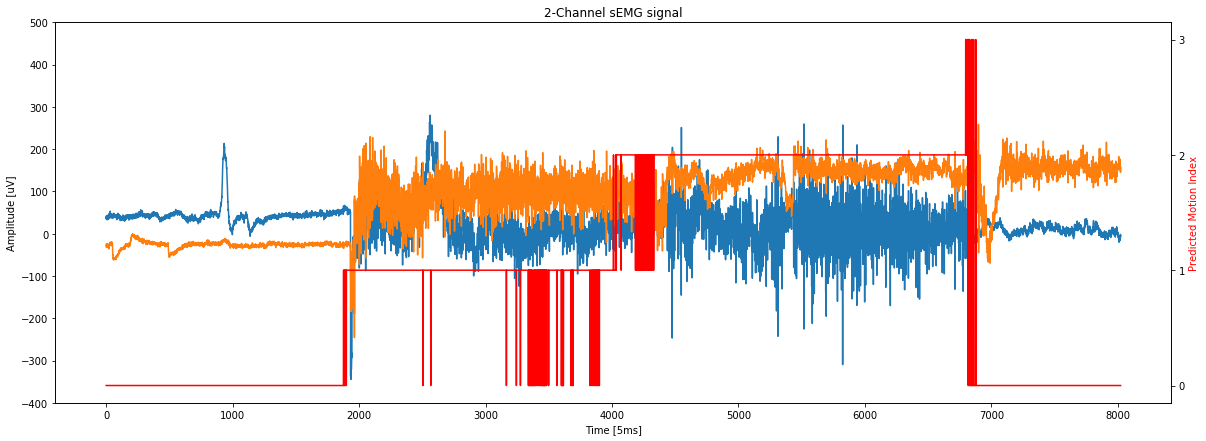

In [97]:
plt.figure(figsize=(20,7))

plt.title('2-Channel sEMG signal')

path_ = "_Pred.txt"
result = pd.read_csv(path_).values

plt.ylim(-400,500)
plt.ylabel('Amplitude [uV]')
plt.xlabel('Time [5ms]')
rData = train_input[:,0]
rDataNum = rData.shape[0]
ax1 = plt.plot(range(rDataNum), rData)

ax2 = plt.gca().twinx()
plt.ylabel('Predicted Motion Index', color = 'r')
plt.xlabel('Time [5ms]')
plt.yticks([0,1,2,3])
rData = np.asarray(result)
rData = rData[:,]
rDataNum = rData.shape[0]
plt.plot(range(rDataNum), rData, color = 'r')


plt.show